In [1]:
import networkx as nx
from RJW import *
import seaborn as sns
from custom_svc import *
from ot_distances import RJW_distance
import matplotlib.pyplot as plt
from graph import  Graph
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [2]:
np.random.seed(50)

X_2_train = []
for _ in range(200): 
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:2]
        G.add_edges_from([(i,nn[0]),(i,nn[1])])
    
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_2_train.append(G)

X_3_train = []

for _ in range(200):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:3]
        G.add_edges_from([(i,nn[0]),(i,nn[1]), (i,nn[2])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_3_train.append(G)

X_2_test = []


for _ in range(50):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:2]
        G.add_edges_from([(i,nn[0]),(i,nn[1])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_2_test.append(G)


X_3_test = []


for _ in range(50):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:3]
        G.add_edges_from([(i,nn[0]),(i,nn[1]), (i,nn[2])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_3_test.append(G)



Exemple de graphe

In [3]:
nx.is_connected(X_2_train[0])

False

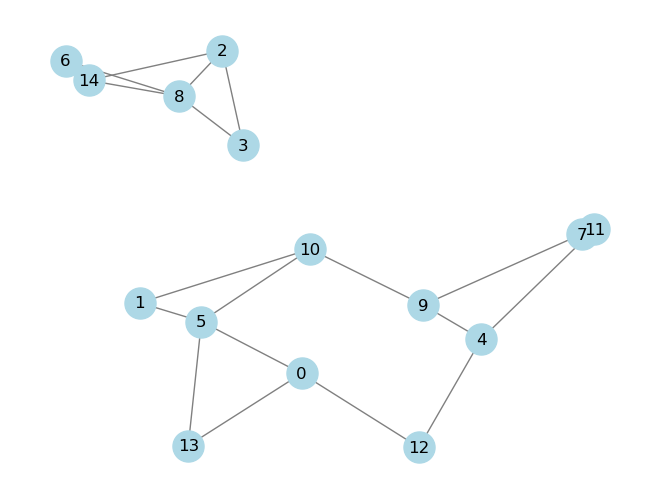

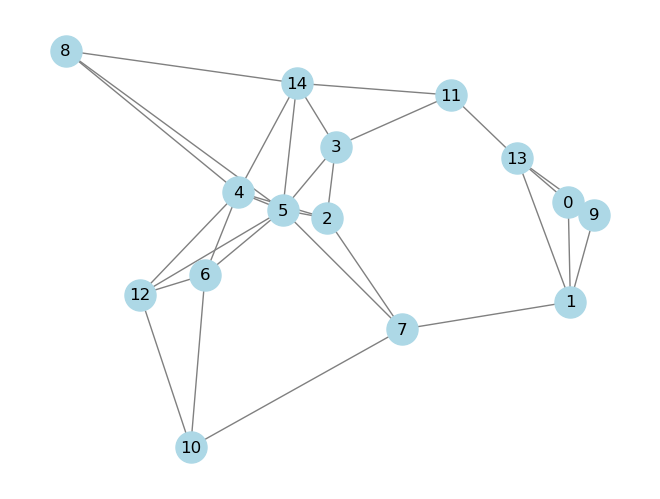

In [4]:

G_first = X_2_train[0]
positions = nx.get_node_attributes(G_first, 'y')
nx.draw(G_first, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

G_first = X_3_train[0]
positions = nx.get_node_attributes(G_first, 'y')
nx.draw(G_first, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [5]:
count=0
for i in range(len(X_2_train)): 
    if nx.is_connected(X_2_train[i]) : 
        count+=1
print(str(100*count/len(X_2_train)) + '% of the 2nn graphs are connected')
count=0
for i in range(len(X_3_train)): 
    if nx.is_connected(X_3_train[i]) : 
        count+=1
print(str(100*count/len(X_3_train)) + '% of the 3nn graphs are connected')


56.5% of the 2nn graphs are connected
90.0% of the 3nn graphs are connected


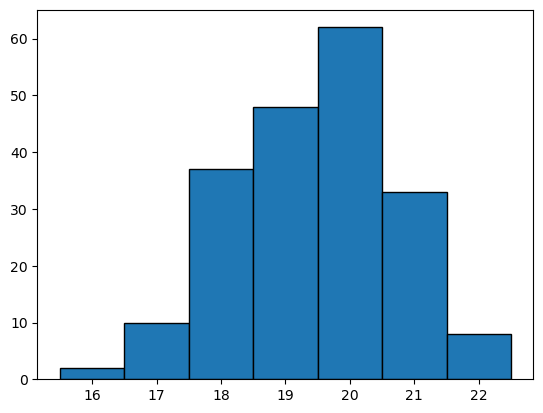

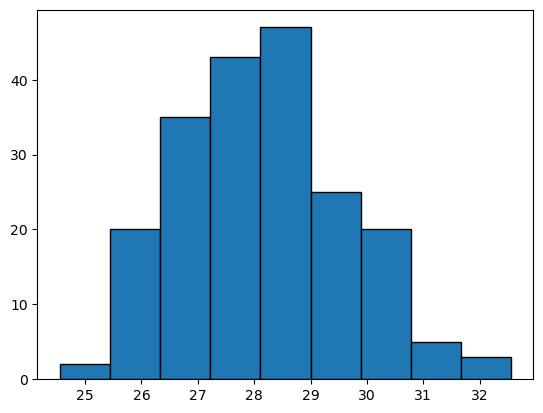

mean number of edges in 2nn graphs : 19.45
mean number of edges in 3nn graphs : 28.555


In [6]:
edges_2=[len(X.edges()) for X in X_2_train]
plt.hist(edges_2, bins=7, edgecolor='black', align = 'left')    
plt.show()

edges_3=[len(X.edges()) for X in X_3_train]
plt.hist(edges_3, bins=9, edgecolor='black', align  = 'left')
plt.show()

print('mean number of edges in 2nn graphs : ' + str(np.mean(edges_2)))
print('mean number of edges in 3nn graphs : ' + str(np.mean(edges_3)))


In [7]:
X_train, y_train = (X_2_train + X_3_train),np.array( [0]*len(X_2_train) + [1]*len(X_3_train))

X_test, y_test = (X_2_test + X_3_test), np.array([0]*len(X_2_test) + [1]*len(X_3_test))

In [8]:
# mean number of edges
mean_edges = np.mean([len(X.edges()) for X in X_2_train])
print('mean number of edges in 2nn graphs :', mean_edges)


mean_edges = np.mean([len(X.edges()) for X in X_3_train])
print('mean number of edges in 2nn graphs :', mean_edges)


mean number of edges in 2nn graphs : 19.45
mean number of edges in 2nn graphs : 28.555


In [9]:
def convert_list_in_array(l): 
    array = np.empty(len(l), dtype=object)
    for i in range(len(l)):
        array[i] = l[i]
    return array

In [10]:
X_train_bis = []
X_test_bis = []

for g in X_train: 
    my_graph = Graph(g)
    my_graph.distance_matrix()
    X_train_bis.append(my_graph)
for g in X_test: 
    my_graph = Graph(g)
    my_graph.distance_matrix()
    X_test_bis.append(my_graph)


X_train_bis = convert_list_in_array(X_train_bis)
X_test_bis = convert_list_in_array(X_test_bis)



c:\Users\grego\miniconda3\envs\map588\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

classifier = Graph_RJW_SVC_Classifier()
classifier.fit(X_train_bis, y_train)
# print('score : ',classifier.score(X_test_bis, y_test))


10
NonConvergenceError for  <graph.Graph object at 0x000001B05F415250> <graph.Graph object at 0x000001B05F7CEA00>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05F3AB340> <graph.Graph object at 0x000001B05F7CEC40>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05F3AB340> <graph.Graph object at 0x000001B05F844970>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05F3AB340> <graph.Graph object at 0x000001B05F844D60>
8
NonConvergenceError for  <graph.Graph object at 0x000001B05F3F9460> <graph.Graph object at 0x000001B05F5B2850>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05F3F9460> <graph.Graph object at 0x000001B05F67CCD0>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05F40A3A0> <graph.Graph object at 0x000001B05F3F9640>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05F40C640> <graph.Graph object at 0x000001B05F54D460>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05F40C760> <graph.Graph object a

In [12]:
prediction_was = classifier.predict(X_test_bis)
print('prediction : ',prediction_was)
print('true labels : ',y_test)

8
NonConvergenceError for  <graph.Graph object at 0x000001B05FA20610> <graph.Graph object at 0x000001B05F7CEFA0>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05FA20970> <graph.Graph object at 0x000001B05F54D220>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05FA20970> <graph.Graph object at 0x000001B05F54DA90>
8
NonConvergenceError for  <graph.Graph object at 0x000001B05FA20B20> <graph.Graph object at 0x000001B05F67C8E0>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05FA8D070> <graph.Graph object at 0x000001B05F932970>
8
NonConvergenceError for  <graph.Graph object at 0x000001B05FA8D190> <graph.Graph object at 0x000001B05F67C8E0>
9
NonConvergenceError for  <graph.Graph object at 0x000001B05FA8D2B0> <graph.Graph object at 0x000001B05F415D00>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05FA8D580> <graph.Graph object at 0x000001B05F8BA100>
10
NonConvergenceError for  <graph.Graph object at 0x000001B05FA8D730> <graph.Graph object at 

In [13]:
# import f1 score
print('f1 score : ',f1_score(y_test, prediction_was))
print('accuracy', np.mean(prediction_was == y_test))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [14]:
# random forest 
classifier = RandomForestClassifier()
classifier.fit([X_train_bis[i].distance_matrix()[0].flatten() for i in range(len(X_train_bis))], y_train)
prediction_rf = classifier.predict([X_test_bis[i].distance_matrix()[0].flatten() for i in range(len(X_test_bis))])
print('prediction : ',prediction_rf)
print('true labels : ',y_test)
print('f1 score : ',f1_score(y_test, prediction_rf))
print('accuracy', np.mean(prediction_rf == y_test))



prediction :  [0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1]
true labels :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
f1 score :  0.6666666666666666
accuracy 0.68


In [15]:
# kernel method with gaussiao kernel
classifier = SVC(kernel='rbf')
classifier.fit([X_train_bis[i].distance_matrix()[0].flatten() for i in range(len(X_train_bis))], y_train)
prediction_gauss = classifier.predict([X_test_bis[i].distance_matrix()[0].flatten() for i in range(len(X_test_bis))])
print('prediction : ',prediction_gauss)
print('true labels : ',y_test)
print('f1 score : ',f1_score(y_test, prediction_gauss))
print('accuracy', np.mean(prediction_gauss == y_test))


prediction :  [0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1
 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0]
true labels :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
f1 score :  0.5681818181818182
accuracy 0.62
